# Question B

For this project, we created a class called Ising 2D. We initialize the model using an LxL lattice. Therefore, the model object starts with the following attributes:
* L : Linear size of the square lattice 
* Initial_state: a string value that allows us to choose how we would like the spins to be oriented at the beginning (all up, all down or random)
* H: External magnetic field strength 
* J: Interaction magnetic field strength 


<>:305: SyntaxWarning: invalid escape sequence '\l'
<>:317: SyntaxWarning: invalid escape sequence '\c'
<>:305: SyntaxWarning: invalid escape sequence '\l'
<>:317: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bpiguave\AppData\Local\Temp\ipykernel_17224\583734404.py:305: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_ylabel('Average Absolute Magnetization per Site $\langle|M|\\rangle/N$')
C:\Users\bpiguave\AppData\Local\Temp\ipykernel_17224\583734404.py:317: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('Susceptibility per Site $\chi/N$')


--- Ising Model Simulation ---

Simulating spin trajectory...
--- Starting trajectory simulation for L=10, T=2.27 ---
Equilibrating for 500 steps at T=2.27...
Running simulation for 1500 steps at T=2.27...
--- Finished trajectory simulation ---


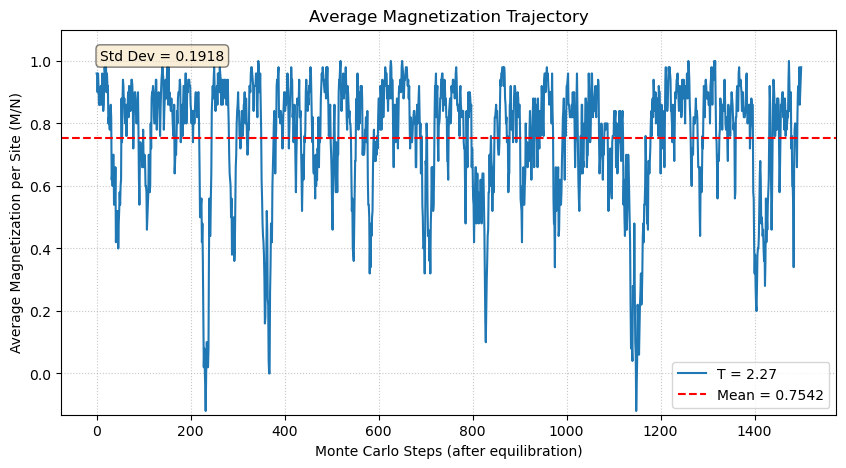


Calculating M and Chi vs T...

--- Simulating for L = 8 ---


L=8:   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...
Running simulation for 4000 steps at T=1.00...
Equilibrating for 1000 steps at T=1.10...
Running simulation for 4000 steps at T=1.10...
Equilibrating for 1000 steps at T=1.20...
Running simulation for 4000 steps at T=1.20...
Equilibrating for 1000 steps at T=1.30...
Running simulation for 4000 steps at T=1.30...
Equilibrating for 1000 steps at T=1.40...
Running simulation for 4000 steps at T=1.40...
Equilibrating for 1000 steps at T=1.50...
Running simulation for 4000 steps at T=1.50...
Equilibrating for 1000 steps at T=1.60...
Running simulation for 4000 steps at T=1.60...
Equilibrating for 1000 steps at T=1.70...
Running simulation for 4000 steps at T=1.70...
Equilibrating for 1000 steps at T=1.80...
Running simulation for 4000 steps at T=1.80...
Equilibrating for 1000 steps at T=1.90...
Running simulation for 4000 steps at T=1.90...
Equilibrating for 1000 steps at T=2.00...


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter, tqdm for standard Python
import random

class Ising2D:
    """
    Implements a 2D Ising model simulation using the Metropolis Monte Carlo algorithm.
    """
    def __init__(self, L, initial_state='random', J=1.0, H=0.0):
        """
        Initializes the Ising model on an LxL lattice.

        Args:
            L (int): Linear size of the square lattice.
            initial_state (str): 'random' for random initial spins, 'up' for all spins +1,
                                 'down' for all spins -1.
            J (float): Interaction strength (J > 0 for ferromagnetic).
            H (float): External magnetic field strength.
        """
        self.L = L
        self.N = L * L  # Total number of spins
        self.J = J
        self.H = H

        if initial_state == 'random':
            # Assign +1 or -1 randomly to each site
            self.lattice = np.random.choice([1, -1], size=(L, L))
        elif initial_state == 'up':
            self.lattice = np.ones((L, L), dtype=int)
        elif initial_state == 'down':
            self.lattice = -np.ones((L, L), dtype=int)
        else:
            raise ValueError("initial_state must be 'random', 'up', or 'down'")

        # Precompute neighbors for faster access (optional but can speed up)
        # self._neighbors = self._precompute_neighbors() # Example optimization

    def get_neighbors_sum(self, i, j):
        """
        Calculates the sum of the nearest neighbor spins for site (i, j)
        using periodic boundary conditions.

        Args:
            i (int): Row index.
            j (int): Column index.

        Returns:
            int: Sum of the four nearest neighbor spins.
        """
        L = self.L
        s = self.lattice # Alias for easier reading

        # Periodic boundary conditions using modulo operator
        top    = s[(i - 1) % L, j]
        bottom = s[(i + 1) % L, j]
        left   = s[i, (j - 1) % L]
        right  = s[i, (j + 1) % L]

        return top + bottom + left + right

    def _calculate_delta_E(self, i, j):
        """
        Calculates the change in energy if the spin at (i, j) is flipped.
        ΔE = E_final - E_initial = -2 * s_ij * (J * sum_neighbors + H)
        """
        spin_ij = self.lattice[i, j]
        neighbors_sum = self.get_neighbors_sum(i, j)
        delta_E = 2 * spin_ij * (self.J * neighbors_sum + self.H)
        return delta_E

    def calculate_energy(self):
        """
        Calculates the total energy of the lattice.
        E = -J Σ_<i,j> s_i s_j - H Σ_i s_i
        The sum Σ_<i,j> is over nearest neighbor pairs (each pair counted once).
        """
        energy = 0.0
        for i in range(self.L):
            for j in range(self.L):
                # Interaction term: sum over neighbors to the right and down to avoid double counting
                spin_ij = self.lattice[i, j]
                neighbor_sum = self.lattice[i, (j + 1) % self.L] + self.lattice[(i + 1) % self.L, j]
                energy += -self.J * spin_ij * neighbor_sum
                # Field term
                energy += -self.H * spin_ij
        return energy

    def calculate_magnetization(self):
        """
        Calculates the total magnetization of the lattice.
        M = Σ_i s_i
        """
        return np.sum(self.lattice)

    def monte_carlo_step(self, beta):
        """
        Performs one Monte Carlo step using the Metropolis algorithm.
        One step consists of N attempted spin flips (where N = L*L).

        Args:
            beta (float): Inverse temperature (1 / (k_B * T)). k_B is assumed to be 1.
        """
        for _ in range(self.N):
            # 1. Choose a random spin site
            i = random.randrange(self.L) # More efficient than np.random.randint for single numbers
            j = random.randrange(self.L)

            # 2. Calculate the energy change if this spin is flipped
            delta_E = self._calculate_delta_E(i, j)

            # 3. Metropolis acceptance criterion
            # If ΔE < 0 (energy decreases), always accept the flip.
            # If ΔE > 0 (energy increases), accept with probability exp(-ΔE * beta).
            if delta_E < 0 or random.random() < np.exp(-delta_E * beta):
                self.lattice[i, j] *= -1 # Flip the spin

    def run_simulation(self, T, num_steps, equilibration_steps=500):
        """
        Runs the Monte Carlo simulation for a given temperature.

        Args:
            T (float): Temperature (k_B is assumed to be 1).
            num_steps (int): Total number of Monte Carlo steps (each step = N spin flips).
            equilibration_steps (int): Number of initial steps to discard for equilibration.

        Returns:
            tuple: (energies, magnetizations)
                   - energies (list): List of total energy per site (E/N) at each step after equilibration.
                   - magnetizations (list): List of magnetization per site (M/N) at each step after equilibration.
        """
        if T <= 0:
             # Handle T=0 or negative T if necessary, or raise error
             if T == 0: beta = np.inf
             else: raise ValueError("Temperature must be positive.")
        else:
             beta = 1.0 / T

        energies = []
        magnetizations = []

        print(f"Equilibrating for {equilibration_steps} steps at T={T:.2f}...")
        for step in range(equilibration_steps):
            self.monte_carlo_step(beta)

        print(f"Running simulation for {num_steps - equilibration_steps} steps at T={T:.2f}...")
        for step in range(equilibration_steps, num_steps):
            self.monte_carlo_step(beta)
            # Record energy and magnetization after equilibration
            energy = self.calculate_energy()
            magnetization = self.calculate_magnetization()
            energies.append(energy / self.N)
            magnetizations.append(magnetization / self.N)

        return energies, magnetizations

    def get_lattice(self):
        """
        Returns the current state of the lattice.
        """
        return self.lattice.copy() # Return a copy to prevent external modification

# --- Analysis Functions ---

def test_random_uniform(num_samples=10000):
    """
    Tests the uniformity of the standard random number generator `random.random()`.
    Generates samples and plots their histogram.

    Args:
        num_samples (int): Number of random samples to generate.
    """
    samples = [random.random() for _ in range(num_samples)]
    plt.figure(figsize=(8, 6))
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='Sampled Distribution')
    plt.axhline(1.0, color='r', linestyle='--', label='Ideal Uniform Distribution')
    plt.title(f'Histogram of random.random() Samples (N={num_samples})')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, axis='y', linestyle=':', alpha=0.7)
    plt.show()

def get_average_spin_trajectory(L=20, T=2.0, num_steps=1000, equilibration_steps=500):
    """
    Simulates the Ising model and returns the trajectory of the
    average magnetization per site after equilibration.

    Args:
        L (int): Lattice size.
        T (float): Temperature.
        num_steps (int): Total simulation steps.
        equilibration_steps (int): Steps to discard for equilibration.

    Returns:
        list: Trajectory of average magnetization per site (M/N) after equilibration.
    """
    print(f"--- Starting trajectory simulation for L={L}, T={T:.2f} ---")
    model = Ising2D(L=L, initial_state='random')
    _, magnetizations = model.run_simulation(T, num_steps, equilibration_steps)
    print(f"--- Finished trajectory simulation ---")
    return magnetizations # This is M/N trajectory

def plot_average_spin_trajectory(trajectory, T):
    """
    Plots the average magnetization per site trajectory.

    Args:
        trajectory (list): List of average magnetization per site values.
        T (float): Temperature at which the simulation was run.
    """
    plt.figure(figsize=(10, 5))
    steps = np.arange(len(trajectory))
    plt.plot(steps, trajectory, label=f'T = {T:.2f}')
    plt.xlabel('Monte Carlo Steps (after equilibration)')
    plt.ylabel('Average Magnetization per Site (M/N)')
    plt.title('Average Magnetization Trajectory')
    # Calculate and display the mean and std dev of the trajectory
    mean_M = np.mean(trajectory)
    std_M = np.std(trajectory)
    plt.axhline(mean_M, color='r', linestyle='--', label=f'Mean = {mean_M:.4f}')
    plt.text(0.05, 0.95, f'Std Dev = {std_M:.4f}', transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(min(trajectory)-0.1*abs(min(trajectory)), max(trajectory)+0.1*abs(max(trajectory))) # Adjust y-lim slightly
    plt.show()


def calculate_magnetization_and_susceptibility(L, T, num_steps=5000, equilibration_steps=1000):
    """
    Runs simulation and calculates the average absolute magnetization per site
    and magnetic susceptibility per site.

    Args:
        L (int): Lattice size.
        T (float): Temperature.
        num_steps (int): Total simulation steps.
        equilibration_steps (int): Steps to discard for equilibration.

    Returns:
        tuple: (avg_abs_mag_per_site, susceptibility_per_site)
               - avg_abs_mag_per_site: <|M|>/N
               - susceptibility_per_site: χ/N = (β / N) * (<M^2> - <M>^2)
    """
    if T <= 0: beta = np.inf
    else: beta = 1.0 / T

    model = Ising2D(L=L, initial_state='random') # Start fresh for each T
    N = model.N
    _, magnetizations_norm = model.run_simulation(T, num_steps, equilibration_steps)

    # Convert normalized magnetizations (M/N) back to total M for calculations
    magnetizations_total = [m * N for m in magnetizations_norm]

    # Use measurements *after* equilibration
    M_vals = np.array(magnetizations_total) # Total M values
    M_abs_vals = np.abs(M_vals)             # Absolute |M| values

    # Average absolute magnetization per site: <|M|> / N
    avg_abs_mag_per_site = np.mean(M_abs_vals) / N

    # Susceptibility per site: χ/N = (β / N) * (<M^2> - <M>^2)
    # Note: Using <M>^2 is standard. If M fluctuates around 0 (high T), <M> ≈ 0.
    # If M fluctuates around non-zero M_0 (low T), <M> ≈ M_0.
    M_sq_avg = np.mean(M_vals**2)
    M_avg_sq = np.mean(M_vals)**2
    susceptibility_per_site = (beta / N) * (M_sq_avg - M_avg_sq) if T > 0 else 0.0

    return avg_abs_mag_per_site, susceptibility_per_site

def plot_magnetization_and_susceptibility_vs_T(L_values, T_range):
    """
    Calculates and plots average magnetization and susceptibility vs. temperature
    for different lattice sizes L.

    Args:
        L_values (list or array): List of lattice sizes L to simulate.
        T_range (list or array): Range of temperatures T to simulate.
    """
    results = {} # Store results as {L: {'T': [], 'M': [], 'Chi': []}}

    num_steps=5000          # Adjust as needed for accuracy
    equilibration_steps=1000 # Adjust as needed

    for L in L_values:
        print(f"\n--- Simulating for L = {L} ---")
        results[L] = {'T': [], 'M': [], 'Chi': []}
        # Use tqdm for progress bar over temperatures
        for T in tqdm(T_range, desc=f"L={L}"):
            avg_M_abs_norm, susc_norm = calculate_magnetization_and_susceptibility(
                L, T, num_steps=num_steps, equilibration_steps=equilibration_steps
            )
            results[L]['T'].append(T)
            results[L]['M'].append(avg_M_abs_norm)
            results[L]['Chi'].append(susc_norm)

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

    # Plot Magnetization
    ax1 = axes[0]
    for L in L_values:
        ax1.plot(results[L]['T'], results[L]['M'], 'o-', markersize=4, label=f'L={L}')
    ax1.set_ylabel('Average Absolute Magnetization per Site $\langle|M|\\rangle/N$')
    ax1.set_title('Ising Model: Magnetization vs. Temperature')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.7)

    # Plot Susceptibility
    ax2 = axes[1]
    Tc_exact = 2 / np.log(1 + np.sqrt(2)) # Exact Tc for infinite 2D Ising model
    for L in L_values:
        ax2.plot(results[L]['T'], results[L]['Chi'], 'o-', markersize=4, label=f'L={L}')
    ax2.axvline(Tc_exact, color='grey', linestyle='--', label=f'$T_c$ (exact) ≈ {Tc_exact:.4f}')
    ax2.set_xlabel('Temperature (T)')
    ax2.set_ylabel('Susceptibility per Site $\chi/N$')
    ax2.set_title('Ising Model: Susceptibility vs. Temperature')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.7)
    # Optional: Set y-limit for susceptibility if peaks get very high
    # max_chi = max(max(results[L]['Chi']) for L in L_values if results[L]['Chi'])
    # ax2.set_ylim(0, max_chi * 1.1)


    plt.tight_layout()
    plt.show()

    # Return results dictionary for further analysis if needed
    return results


def estimate_critical_temperature_and_gamma(L_values, T_range, num_steps=5000, equilibration_steps=1000):
    """
    Estimates the critical temperature Tc by finding the peak of the susceptibility
    for the largest lattice size. Also discusses how gamma could be estimated.

    Args:
        L_values (list or array): List of lattice sizes L simulated.
        T_range (list or array): Range of temperatures T simulated.
        num_steps (int): Simulation steps used (passed to calculation).
        equilibration_steps (int): Equilibration steps used (passed to calculation).

    Returns:
        float: Estimated critical temperature Tc based on susceptibility peak of largest L.
    """
    # Re-run or use pre-computed results if available
    # For simplicity, let's assume we need to compute it here
    results = {}
    print("\n--- Calculating Susceptibility for Tc Estimation ---")
    for L in L_values:
        results[L] = {'T': [], 'Chi': []}
        for T in tqdm(T_range, desc=f"Estimating Tc (L={L})"):
             _, susc_norm = calculate_magnetization_and_susceptibility(
                L, T, num_steps=num_steps, equilibration_steps=equilibration_steps
            )
             results[L]['T'].append(T)
             results[L]['Chi'].append(susc_norm)


    # Find Tc estimate from the peak of Chi for the largest L
    largest_L = max(L_values)
    chi_values = np.array(results[largest_L]['Chi'])
    temp_values = np.array(results[largest_L]['T'])

    if len(chi_values) > 0:
        peak_index = np.argmax(chi_values)
        Tc_estimated = temp_values[peak_index]
        peak_chi = chi_values[peak_index]
        print(f"\nEstimated Critical Temperature (Tc) from peak of χ for L={largest_L}: {Tc_estimated:.4f}")
        print(f"Peak Susceptibility (χ/N) at L={largest_L}: {peak_chi:.4f}")
        print("\nTo estimate gamma (γ):")
        print("1. Find the peak susceptibility (χ_max) for each lattice size L.")
        print("2. Plot log(χ_max) against log(L).")
        print("3. The slope of this plot (for large L) approximates γ (since ν=1 in 2D Ising).")
        # Example (requires chi_max values for multiple L):
        # log_L = np.log([L for L in L_values])
        # log_chi_max = np.log([np.max(results[L]['Chi']) for L in L_values])
        # plt.plot(log_L, log_chi_max, 'o-')
        # plt.xlabel('log(L)')
        # plt.ylabel('log(χ_max/N)')
        # plt.title('Finite-Size Scaling of Susceptibility Peak')
        # plt.show()
        # fit = np.polyfit(log_L, log_chi_max, 1) # Slope is estimate for gamma
        # print(f"Estimated gamma from slope: {fit[0]:.4f} (Exact 2D Ising gamma = 7/4 = 1.75)")

        return Tc_estimated
    else:
        print("No susceptibility data available to estimate Tc.")
        return None

def calculate_correlation_function(model, r):
    """
    (Placeholder) Calculates the spin-spin correlation function G(r).
    G(r) = <s_i * s_{i+r}> - <si><s_{i+r}> = <s_i * s_{i+r}> - <M/N>^2 (if homogeneous)
    Averaging is over all pairs (i, i+r) and over simulation time.

    Args:
        model (Ising2D): The Ising model instance (after simulation).
        r (int): The distance between spins.

    Returns:
        float: The calculated correlation function G(r). (Currently returns None)
    """
    # This function needs significant implementation:
    # 1. Decide on the definition of distance 'r' (e.g., horizontal, vertical, radial).
    # 2. Need to run a simulation and collect spin configurations over time *after* equilibration.
    # 3. For each configuration:
    #    - Iterate through all sites 'i'.
    #    - Identify site(s) 'j' at distance 'r' from 'i' (handling boundaries).
    #    - Calculate s_i * s_j for these pairs.
    #    - Average s_i * s_j over all valid pairs in the configuration.
    # 4. Average the result from step 3 over all collected configurations.
    # 5. Calculate the average magnetization <M/N> from the simulation run.
    # 6. Compute G(r) = <s_i * s_{i+r}>_avg - <M/N>^2.

    print(f"Note: calculate_correlation_function(r={r}) is not fully implemented.")
    # Example for horizontal correlation:
    # lattice = model.get_lattice()
    # L = model.L
    # N = model.N
    # correlation_sum = 0
    # pairs_count = 0
    # for i in range(L):
    #     for j in range(L):
    #         s_i = lattice[i, j]
    #         s_j = lattice[i, (j + r) % L] # Horizontal neighbor at distance r
    #         correlation_sum += s_i * s_j
    #         pairs_count += 1
    # avg_sisj_config = correlation_sum / pairs_count # Need to average this over many configs

    # Placeholder return
    return None


# --- Main execution block (Example Usage) ---
print("--- Ising Model Simulation ---")

# 1. Test the random number generator (optional)
# print("\nTesting random number generator...")
# test_random_uniform(num_samples=20000)

# 2. Simulate and plot average spin trajectory for one case
print("\nSimulating spin trajectory...")
L_traj = 10
T_traj = 2.27 # Near Tc
# T_traj = 1.5 # Ferromagnetic phase
# T_traj = 3.0 # Paramagnetic phase
traj_steps = 2000
traj_eq_steps = 500
avg_spin_traj = get_average_spin_trajectory(L=L_traj, T=T_traj, num_steps=traj_steps, equilibration_steps=traj_eq_steps)
plot_average_spin_trajectory(avg_spin_traj, T_traj)

# 3. Calculate and plot Magnetization and Susceptibility vs. T
print("\nCalculating M and Chi vs T...")
L_values_analysis = [8, 16, 32] # Use larger L for better results near Tc
# T_range_analysis = np.linspace(1.5, 3.5, 41) # Fine grid around Tc_exact ≈ 2.269
T_range_analysis = np.concatenate([
    np.linspace(1.0, 2.0, 11), # Low T region
    np.linspace(2.05, 2.55, 21), # Around Tc region (finer steps)
    np.linspace(2.6, 4.0, 8)    # High T region
])

results_data = plot_magnetization_and_susceptibility_vs_T(L_values_analysis, T_range_analysis)

# 4. Estimate Critical Temperature
print("\nEstimating Critical Temperature...")
Tc_est = estimate_critical_temperature_and_gamma(
    L_values = L_values_analysis,
    T_range = T_range_analysis, # Use the same T range for consistency
    num_steps = 5000, # Match steps used in plot function or adjust
    equilibration_steps = 1000
)
if Tc_est is not None:
    Tc_exact = 2 / np.log(1 + np.sqrt(2))
    print(f"Comparison: Exact Tc (infinite lattice) ≈ {Tc_exact:.4f}")


# 5. Placeholder for Correlation Function (Example call)
print("\nCorrelation Function (Placeholder)...")
# Need a model instance first, e.g., after a run
model_corr = Ising2D(L=16)
# Run a simulation to get an equilibrated state (or average over many states)
model_corr.run_simulation(T=2.0, num_steps=1000, equilibration_steps=500)
G_r1 = calculate_correlation_function(model_corr, r=1)
G_r5 = calculate_correlation_function(model_corr, r=5)
print(f"G(r=1) = {G_r1}")
print(f"G(r=5) = {G_r5}")

print("\n--- Simulation Complete ---")
